## 1日の中で時間ごとの歩数の遷移をモデル化する

### ランダムで9人の10日間の歩数を時間ごとに描画

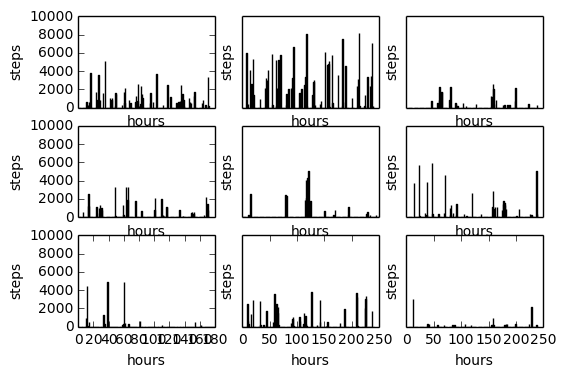

In [2]:
%matplotlib inline
import random
import numpy
import matplotlib.pylab as plt

f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['all']

f, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        datasets = X[random.randint(0, X.shape[0] - 1)]
        # print 'dataset: ', dataset
        axes[i][j].bar(xrange(240), datasets)
        axes[i][j].set_xlabel('hours')
        axes[i][j].set_ylabel('steps')
        axes[i][j].set_ylim(0, 10000)
        if i != 2:
            axes[i][j].set_xticks([])
        if j != 0:
            axes[i][j].set_yticks([])
plt.show()

### 10日の中で1時間ごとの歩数のヒストグラムを作成

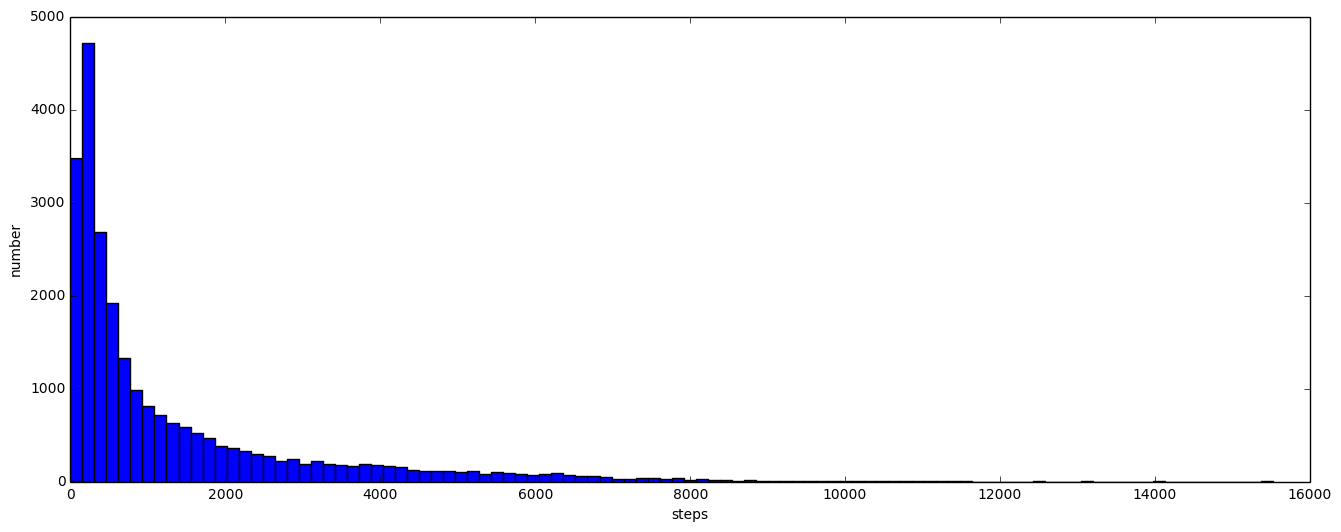

In [3]:
plt.figure(figsize=(16,6))
plt.hist(X[X != 0], bins=100)
plt.ylabel('number')
plt.xlabel('steps')
plt.show()

### 対照群A：現状のレコードで距離が近い順

In [63]:
import numpy
import logging
reload(logging)
logging.basicConfig(level=logging.DEBUG)

def pick_conditional_data(target, src, num=5):
    """
    8000歩以上、かつ、距離が近いものからnum分だけ返す
    """
    dim = target.shape[0]
    ## 各ベクタごとにsumを計算
    sums = numpy.apply_along_axis(lambda x: x.sum(), 1, src)
    ## 8000歩を超えるデータのみ抽出
    sum_cond_cleared = src[sums > 8000]
    ## 条件を満たしたベクタの中で、各ベクタごとに距離を計算
    distances = numpy.apply_along_axis(lambda x: abs(x[:dim].sum() - target.sum()), 1, sum_cond_cleared)
    ## 条件を満たした中で、上位num位を返す
    return sum_cond_cleared[numpy.argsort(distances)[:num]], sum_cond_cleared.shape[0]

### pick_conditional_dataの計算テスト

In [64]:
### 6日目のデータ
day6 = X[:, 5*24:6*24]
alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])
print "picking one from day6 ..."

for i in range(5):
    target = sorted(day6, key=lambda k: random.random())[0]
    print "picked: ", target.shape, target.sum(), ["%d" % x  for x in target]
    choiced, _ = pick_conditional_data(target, alldays)
    print numpy.apply_along_axis(lambda x: x.sum(), 1, choiced)

picking one from day6 ...
picked:  (24,) 1242.0 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1068', '0', '0', '0', '0', '174', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]
picked:  (24,) 0.0 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]
picked:  (24,) 2319.0 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2319', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]
picked:  (24,) 9045.0 ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '527', '741', '0', '3559', '67', '0', '0', '0', '0', '4150', '0', '0', '0']
[ 9045.  9048.  9039.  9029.  9071.]
picked:  (24,) 1085.0 ['0', '0', '0', '0', '0', '0', '0', '281', '0', '0', '0', '632', '0', '0', '0', '0', '0', '0', '0', '0', '172', '0', '0', '0']
[ 8002.  8005.  8005.  8006.  8007.]


### 4時間ずつの検索結果とその距離をだす

(0, 24)

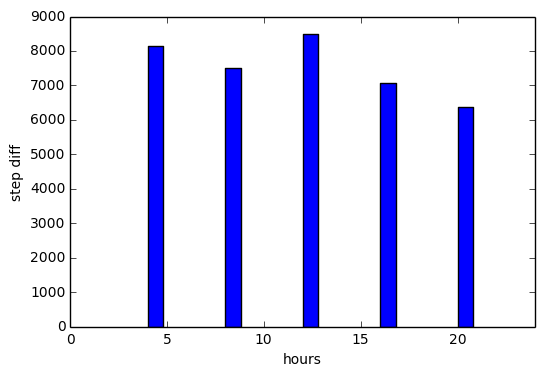

In [65]:
import numpy
import matplotlib.pylab as plt

day6 = X[:, 5*24:6*24]
alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

means_per_hour = []
total_num = []

for limit in numpy.arange(4, 24, 4):
    means = []
    for i in range(X.shape[0] / 10):
        full_target = sorted(day6, key=lambda k: random.random())[0]
        target = full_target[:limit]
        choiced, total_num = pick_conditional_data(target, alldays)
        means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
    means_per_hour.append(numpy.average(means))

plt.bar(numpy.arange(4, 24, 4), means_per_hour)
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)

### 対照群B：クラスタリングしてから検索

In [66]:
from sklearn.cluster import AgglomerativeClustering

clusters = 10

print "Exec Ward Agglomerative Clustering ..."

alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

for type in ["ward", "complete", "average"]:
    print "goinng to", type, "clustering ..."
    ward = AgglomerativeClustering(linkage=type, n_clusters=clusters)
    clustered = ward.fit_predict(alldays)
    print "clustered: ", clustered.shape, clustered.dtype

    for i in range(clusters):
        print "[%d] %d" % (i, numpy.count_nonzero(clustered == i))

Exec Ward Agglomerative Clustering ...
goinng to ward clustering ...
clustered:  (7040,) int64
[0] 907
[1] 265
[2] 137
[3] 4312
[4] 291
[5] 275
[6] 199
[7] 163
[8] 259
[9] 232
goinng to complete clustering ...


KeyboardInterrupt: 

In [67]:
from sklearn.cluster import KMeans

clusters = 10

print "Exec KMeans Clustering ..."

alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

kmeans = KMeans(n_clusters=clusters, random_state=0)
clustered = kmeans.fit_predict(alldays)
print "clustered: ", clustered.shape, clustered.dtype, "max: ", clustered.max(), "min: ", clustered.min()

for i in range(clusters):
    print "[%d] %d" % (i, numpy.count_nonzero(clustered == i))

Exec KMeans Clustering ...
clustered:  (7040,) int32 max:  9 min:  0
[0] 4890
[1] 234
[2] 109
[3] 273
[4] 234
[5] 190
[6] 252
[7] 425
[8] 152
[9] 281


In [ ]:
import numpy
from sklearn.cluster import SpectralClustering

clusters = 10

print "Exec Spectral Clustering ..."

alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

spectral = SpectralClustering(n_clusters=clusters, eigen_solver='arpack', affinity="nearest_neighbors")
clustered = spectral.fit_predict(alldays)
print "clustered: ", clustered.shape, clustered.dtype, "max: ", clustered.max(), "min: ", clustered.min()

for i in range(clusters):
    print "[%d] %d" % (i, numpy.count_nonzero(clustered == i))

Exec Spectral Clustering ...


In [68]:
import numpy
import collections
import matplotlib.pylab as plt

day6 = X[:, 5*24:6*24]
alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

a_means_per_hour = []
b_means_per_hour = []
a_candidates_per_hour = []
b_candidates_per_hour = []
majorities = []

for limit in numpy.arange(4, 24, 4):
    a_means = []
    a_candidates = []
    b_means = []
    b_candidates = []

    for i in range(X.shape[0] / 10):
        idx = random.randint(0, day6.shape[0] - 1)
        full_target = day6[idx]
        target = full_target[:limit]

        ## A pattern
        choiced, total_num = pick_conditional_data(target, alldays)
        a_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        a_candidates.append(total_num)

        ## B pattern
        history = [X[idx, i*24:(i+1)*24] for i in range(5)]
        predicted = kmeans.predict(history)
        cluster_num = predicted[numpy.argmax(predicted)]
        uniques, counts = numpy.unique(predicted, return_counts=True)
        cluster_num_map = dict(zip(uniques, counts))
        majorities.append(float(cluster_num_map[cluster_num])/float(predicted.shape[0]))
        src = alldays[clustered == cluster_num]
        choiced, total_num = pick_conditional_data(target, src)
        b_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        b_candidates.append(total_num)
    
    a_means_per_hour.append(numpy.average(a_means))
    b_means_per_hour.append(numpy.average(b_means))
    a_candidates_per_hour.append(numpy.average(a_candidates))
    b_candidates_per_hour.append(numpy.average(b_candidates))

print "baseline means: ", a_means_per_hour
print "\tcandidates: ", a_candidates_per_hour
print "proposed method means: ", b_means_per_hour
print "\tcandidates: ", b_candidates_per_hour
print "majorities: ", sum(majorities) / float(len(majorities))

baseline means:  [8627.5732, 7132.6694, 8198.8125, 7333.8252, 6893.0806]
	candidates:  [1339.0, 1339.0, 1339.0, 1339.0, 1339.0]
proposed method means:  [8894.5967, 8016.8901, 7947.9312, 6930.8696, 6324.6851]
	candidates:  [137.04285714285714, 140.21428571428572, 142.27142857142857, 145.94285714285715, 138.88571428571427]
majorities:  0.514857142857


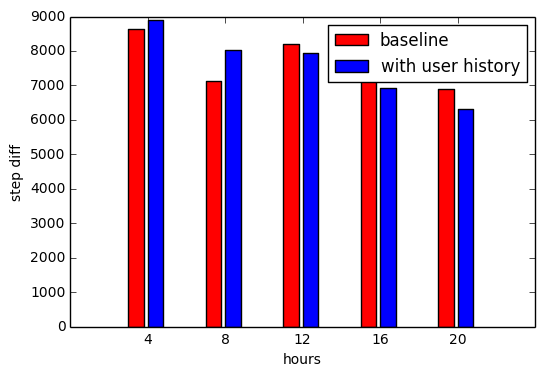

In [69]:
plt.bar(numpy.arange(4, 24, 4) - 1.0, a_means_per_hour, color="red", label="baseline")
plt.bar(numpy.arange(4, 24, 4), b_means_per_hour, label="with user history")
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)
plt.xticks(numpy.arange(4,24,4))
plt.legend()

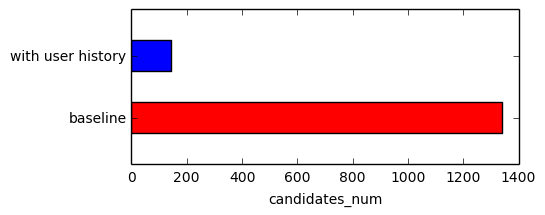

In [39]:
#plt.bar(numpy.arange(4, 24, 4) - 1.0, a_candidates_per_hour, color="red", label="baseline")
#plt.bar(numpy.arange(4, 24, 4), b_candidates_per_hour, label="with user history")
plt.figure(figsize=(5, 2))
plt.barh(1, a_candidates_per_hour[0], color="red", height=1.0)
plt.barh(3, b_candidates_per_hour[0], height=1.0)
plt.xlabel("candidates_num")
#plt.ylabel("candidates_num")
plt.ylim(0, 5)
#plt.xticks([])
plt.yticks([1.5, 3.5], ["baseline", "with user history"])
plt.legend()

### 定量的なパターンマッチングを行なって上記手法と比較してみる
24時間のデータを1ユニットとし、そのユニットごとにクラスタリングを行うのでは、baselineに対して、そこまでの優位性が出なかった。
そこで、次は歩数データを用いたパターンマッチングを行う。
(他にも、差分をとる、１日目と2日目とか、Δとか)

In [14]:
print day6.shape
print alldays.shape
print X.shape

(704, 24)
(7040, 24)
(704, 240)


In [90]:
# これなしだわ8/3
def calculate_matching(cleared, target, dimension):
    # マッチしたデータがあればその距離をリターン
    #if re.match(target, cleared[:dimension]):
    if target is cleared[:dimension]:
        result = abs(x[:dimension].sum() - target.sum())
        return result
    
    # マッチしなかったら選ばれないようになまら大きい数値をリターン
    else:
        return 100000

In [164]:
# ちゃんと定量的なマッチングにするためにはどのくらいまでを同じと見るかの定義が必要
def calculate_matching(cleared, target, dimension):
    matched = []
    for cor, tg in zip(cleared[:dimension], target):
        if (cor < tg and cor+500 > tg) or (cor > tg and cor-500 < tg):
            continue
        else:
            return 100000
        return abs(cleared[:dim].sum() - target.sum())

In [152]:
import re
def pick_matching_data(target, src, num=5):
    """
    8000歩以上、かつ、距離が近いものからnum分だけ返す
    """
    match_list = []
    dim = target.shape[0]
    ## 各ベクタごとにsumを計算
    sums = numpy.apply_along_axis(lambda x: x.sum(), 1, src)
    ## 8000歩を超えるデータのみ抽出
    sum_cond_cleared = src[sums > 8000]
    
    ## 条件を満たしたベクタの中で、各ベクタごとにマッチング
    #distances = numpy.apply_along_axis(lambda x: abs(x[:dim].sum() - target.sum()), 1, sum_cond_cleared)
    for i in sum_cond_cleared:
        match_list = numpy.append(match_list, calculate_matching(i, target, dim))
    ## 条件を満たした中で、上位num位を返す
    #return sum_cond_cleared[numpy.argsort(distances)[:num]], sum_cond_cleared.shape[0]
    return sum_cond_cleared[numpy.argsort(match_list)[:num]], sum_cond_cleared.shape[0]

(0, 24)

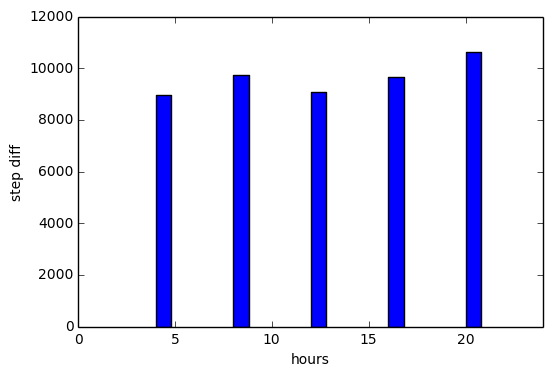

In [163]:
# 全データからパターンマッチングで上位10個取ってきてみようか
means_per_hour_matching = []
total_num_matching = []
for limit in numpy.arange(4, 24, 4):
    means = []
    for i in range(X.shape[0] / 10):
        full_target = sorted(day6, key=lambda k: random.random())[0]
        target = full_target[:limit]
        choiced, total_num = pick_matching_data(target, alldays)
        means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
    #means_per_hour.append(numpy.average(means))
    means_per_hour_matching.append(numpy.average(means))

plt.bar(numpy.arange(4, 24, 4), means_per_hour_matching)
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)

In [160]:
c_means_per_hour = []
c_candidates_per_hour = []
for limit in numpy.arange(4, 24, 4):
    c_means = []
    c_candidates = []
    
    for i in range(X.shape[0] / 10):
        idx = random.randint(0, day6.shape[0] - 1)
        full_target = day6[idx]
        target = full_target[:limit]
        
        ## C pattern
        choiced, total_num = pick_matching_data(target, alldays)
        c_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        c_candidates.append(total_num)
        
    c_means_per_hour.append(numpy.average(c_means))
    c_candidates_per_hour.append(numpy.average(c_candidates))
    
print "matching means: ", c_means_per_hour
print "\tcandidates: ", c_candidates_per_hour

matching means:  [9985.5615, 9911.7764, 9840.1621, 9249.4512, 9594.8018]
	candidates:  [1339.0, 1339.0, 1339.0, 1339.0, 1339.0]


([<matplotlib.axis.XTick at 0x119a7b2d0>,
 <a list of 5 Text xticklabel objects>)

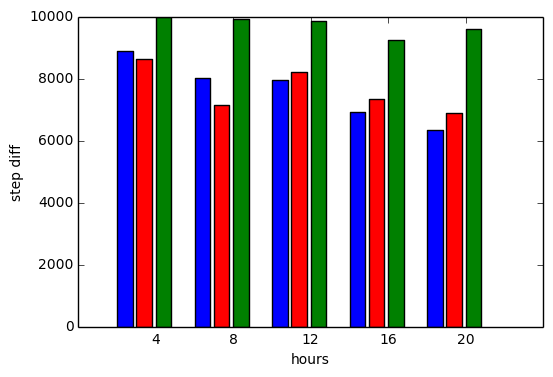

In [161]:
#a: baseline b: with user history c: matching all data
plt.bar(numpy.arange(4, 24, 4) - 1.0, a_means_per_hour, color="red", label="baseline")
plt.bar(numpy.arange(4, 24, 4) - 2.0, b_means_per_hour, label="with user history")
plt.bar(numpy.arange(4, 24, 4), c_means_per_hour, color="green", label="matching all data")
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)
plt.xticks(numpy.arange(4,24,4))
#plt.legend()

### クラスタリングした後にマッチングするのも試してみよう

In [158]:
d_means_per_hour = []
d_candidates_per_hour = []
majorities_matching = []
for limit in numpy.arange(4, 24, 4):
    d_means = []
    d_candidates = []
    
    for i in range(X.shape[0] / 10):
        idx = random.randint(0, day6.shape[0] - 1)
        full_target = day6[idx]
        target = full_target[:limit]    
    
        history = [X[idx, i*24:(i+1)*24] for i in range(5)]
        predicted = kmeans.predict(history)
        cluster_num = predicted[numpy.argmax(predicted)]
        uniques, counts = numpy.unique(predicted, return_counts=True)
        cluster_num_map = dict(zip(uniques, counts))
        majorities_matching.append(float(cluster_num_map[cluster_num])/float(predicted.shape[0]))
        src = alldays[clustered == cluster_num]
        choiced, total_num = pick_matching_data(target, src)
        d_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        d_candidates.append(total_num)
        
    d_means_per_hour.append(numpy.average(d_means))
    d_candidates_per_hour.append(numpy.average(d_candidates))
        
print "matching means: ", d_means_per_hour
print "\tcandidates: ", d_candidates_per_hour

matching means:  [6859.4976, 8368.4482, 7730.8311, 8706.8994, 8446.666]
	candidates:  [138.82857142857142, 135.15714285714284, 151.98571428571429, 148.17142857142858, 144.74285714285713]


([<matplotlib.axis.XTick at 0x1195da510>,
 <a list of 5 Text xticklabel objects>)

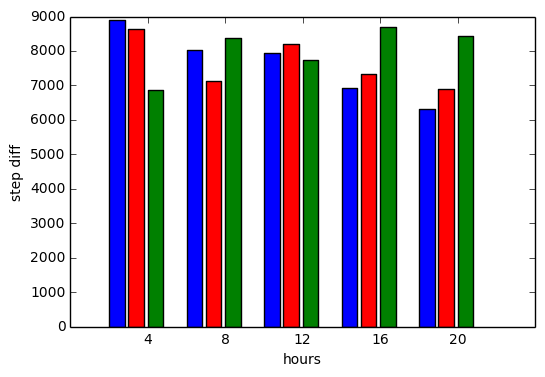

In [159]:
plt.bar(numpy.arange(4, 24, 4) - 1.0, a_means_per_hour, color="red", label="baseline")
plt.bar(numpy.arange(4, 24, 4) - 2.0, b_means_per_hour, label="with user history")
plt.bar(numpy.arange(4, 24, 4), d_means_per_hour, color="green", label="matching in cluster")
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)
plt.xticks(numpy.arange(4,24,4))
#plt.legend()

### 1時間ごとの歩数の差分を取ってその和を元にパターンを推定

In [165]:
def pick_delta_data(target, src, num=5):
    """
    8000歩以上、かつ、距離が近いものからnum分だけ返す
    """
    dim = target.shape[0]
    ## 各ベクタごとにsumを計算
    sums = numpy.apply_along_axis(lambda x: x.sum(), 1, src)
    ## 8000歩を超えるデータのみ抽出
    sum_cond_cleared = src[sums > 8000]
    # ターゲットデータの時間ごとの差分を計算
    target = numpy.diff(target)
    ## 条件を満たしたベクタの中で、各ベクタごとに距離を計算
    distances = numpy.apply_along_axis(lambda x: abs(numpy.diff(x[:dim]).sum() - target.sum()), 1, sum_cond_cleared)
    ## 条件を満たした中で、上位num位を返す
    return sum_cond_cleared[numpy.argsort(distances)[:num]], sum_cond_cleared.shape[0]

(0, 24)

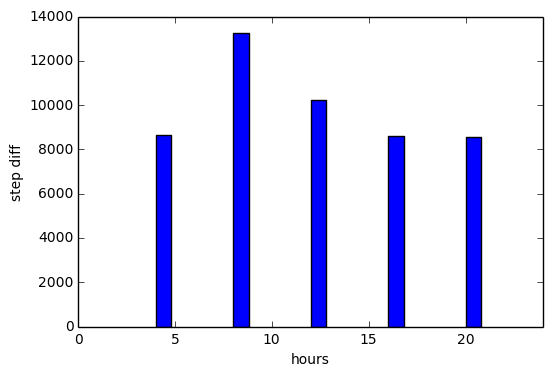

In [171]:
#day6 = X[:, 5*24:6*24]
#alldays = numpy.vstack([X[:, i*24:(i+1)*24] for i in range(10)])

means_per_hour_delta = []
total_num = []

for limit in numpy.arange(4, 24, 4):
    means = []
    for i in range(X.shape[0] / 10):
        full_target = sorted(day6, key=lambda k: random.random())[0]
        target = full_target[:limit]
        choiced, total_num = pick_delta_data(target, alldays)
        means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
    means_per_hour_delta.append(numpy.average(means))

plt.bar(numpy.arange(4, 24, 4), means_per_hour_delta)
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)

In [170]:
e_means_per_hour = []
e_candidates_per_hour = []
for limit in numpy.arange(4, 24, 4):
    e_means = []
    e_candidates = []
    
    for i in range(X.shape[0] / 10):
        idx = random.randint(0, day6.shape[0] - 1)
        full_target = day6[idx]
        target = full_target[:limit]
        
        ## E pattern
        choiced, total_num = pick_delta_data(target, alldays)
        e_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        e_candidates.append(total_num)
        
    e_means_per_hour.append(numpy.average(e_means))
    e_candidates_per_hour.append(numpy.average(e_candidates))
    
print "matching means: ", e_means_per_hour
print "\tcandidates: ", e_candidates_per_hour

matching means:  [7833.0024, 13474.851, 10115.464, 7766.9224, 8523.1543]
	candidates:  [1339.0, 1339.0, 1339.0, 1339.0, 1339.0]


([<matplotlib.axis.XTick at 0x11a07da10>,
 <a list of 5 Text xticklabel objects>)

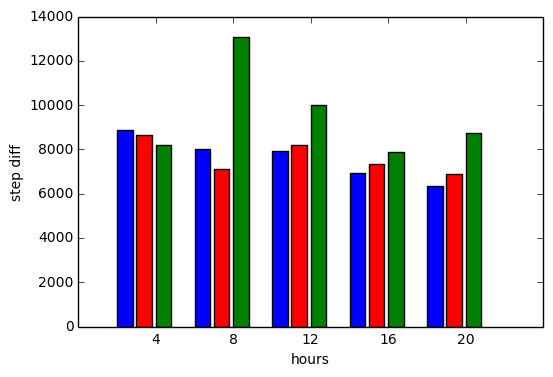

In [168]:
#a: baseline b: with user history e: with delta per hour
plt.bar(numpy.arange(4, 24, 4) - 1.0, a_means_per_hour, color="red", label="baseline")
plt.bar(numpy.arange(4, 24, 4) - 2.0, b_means_per_hour, label="with user history")
plt.bar(numpy.arange(4, 24, 4), e_means_per_hour, color="green", label="with delta per hour")
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)
plt.xticks(numpy.arange(4,24,4))
#plt.legend()

### クラスタリングしたあとに1時間ごとの歩数の差分出すパターン

In [172]:
f_means_per_hour = []
f_candidates_per_hour = []
majorities_matching = []
for limit in numpy.arange(4, 24, 4):
    f_means = []
    f_candidates = []
    
    for i in range(X.shape[0] / 10):
        idx = random.randint(0, day6.shape[0] - 1)
        full_target = day6[idx]
        target = full_target[:limit]    
    
        history = [X[idx, i*24:(i+1)*24] for i in range(5)]
        predicted = kmeans.predict(history)
        cluster_num = predicted[numpy.argmax(predicted)]
        uniques, counts = numpy.unique(predicted, return_counts=True)
        cluster_num_map = dict(zip(uniques, counts))
        majorities_matching.append(float(cluster_num_map[cluster_num])/float(predicted.shape[0]))
        src = alldays[clustered == cluster_num]
        choiced, total_num = pick_delta_data(target, src)
        f_means.append(numpy.apply_along_axis(lambda x: abs(x.sum() - full_target.sum()), 1, choiced).mean())
        f_candidates.append(total_num)
        
    f_means_per_hour.append(numpy.average(f_means))
    f_candidates_per_hour.append(numpy.average(f_candidates))
        
print "matching means: ", f_means_per_hour
print "\tcandidates: ", f_candidates_per_hour

matching means:  [8466.9443, 7737.8545, 8525.8242, 6189.4404, 7474.063]
	candidates:  [142.54285714285714, 146.35714285714286, 143.08571428571429, 144.58571428571429, 142.28571428571428]


([<matplotlib.axis.XTick at 0x11a258f10>,
 <a list of 5 Text xticklabel objects>)

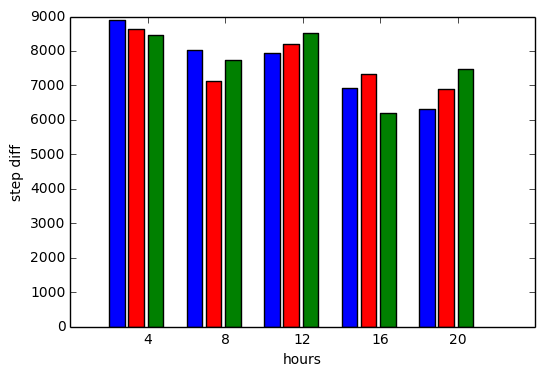

In [173]:
#a: baseline b: with user history e: with delta per hour
plt.bar(numpy.arange(4, 24, 4) - 1.0, a_means_per_hour, color="red", label="baseline")
plt.bar(numpy.arange(4, 24, 4) - 2.0, b_means_per_hour, label="with user history")
plt.bar(numpy.arange(4, 24, 4), f_means_per_hour, color="green", label="with delta per hour")
plt.xlabel("hours")
plt.ylabel("step diff")
plt.xlim(0, 24)
plt.xticks(numpy.arange(4,24,4))
#plt.legend()